# Analysis of the Impact of Government Measures

In [1]:
import pandas as pd
import numpy as np
from pandas import DataFrame
from pandas import concat

import tensorflow as tf
from tensorflow.keras import layers

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures

import matplotlib.pyplot as plt

In [2]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

### load the data

In [3]:
global_df = pd.read_csv("covid_19_data.csv")
con_series_df = pd.read_csv("time_series_covid_19_confirmed.csv")

con_series_df = con_series_df[con_series_df['Country/Region'] == 'Canada']
con_series_df = con_series_df.groupby(['Country/Region']).sum()
con_series_values = con_series_df.drop(columns=['Lat', 'Long']).values
con_series_values = con_series_values.reshape(-1, 1)

days = np.array([i for i in range(con_series_values.shape[0])]).reshape(-1, 1)

### split train and test

In [4]:
X_train, X_test, y_train, y_test = train_test_split(days, con_series_values, test_size=0.05, shuffle=False)

### preprocess

In [5]:
poly = PolynomialFeatures(degree=6)
poly_X_train = poly.fit_transform(X_train)
poly_X_test = poly.fit_transform(X_test)

poly_forecast = poly.fit_transform(days)

### linear regresssion

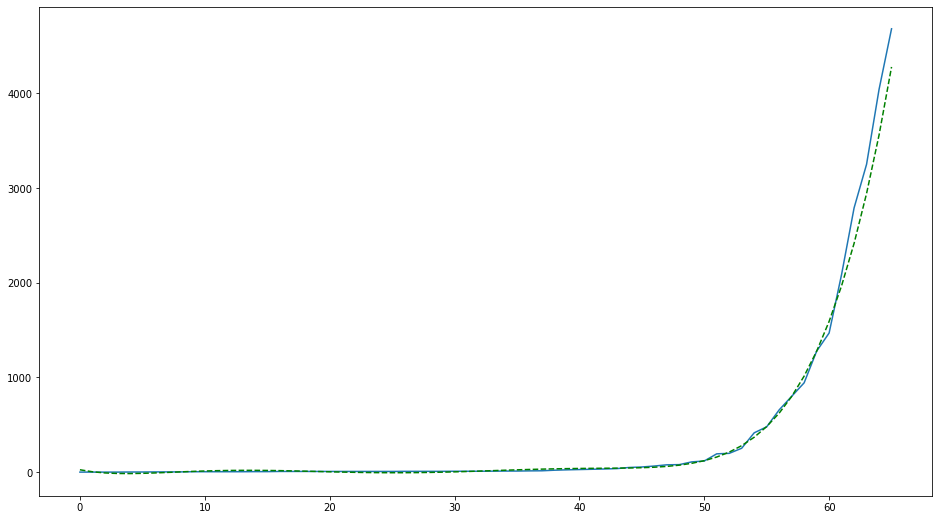

In [6]:
linear_model = LinearRegression(normalize=True, fit_intercept=False)
linear_model.fit(poly_X_train, y_train)
pred = linear_model.predict(poly_forecast)

plt.figure(figsize=(16, 9))
plt.plot(days, con_series_values)
plt.plot(days, pred, linestyle='dashed', color='green')
plt.show()

## time series approach

In [7]:
con_series_values = series_to_supervised(con_series_values, 7, 1).values
days = np.array([i for i in range(con_series_values.shape[0])]).reshape(-1, 1)
X = con_series_values[:, :-1]
y = con_series_values[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, shuffle=False)

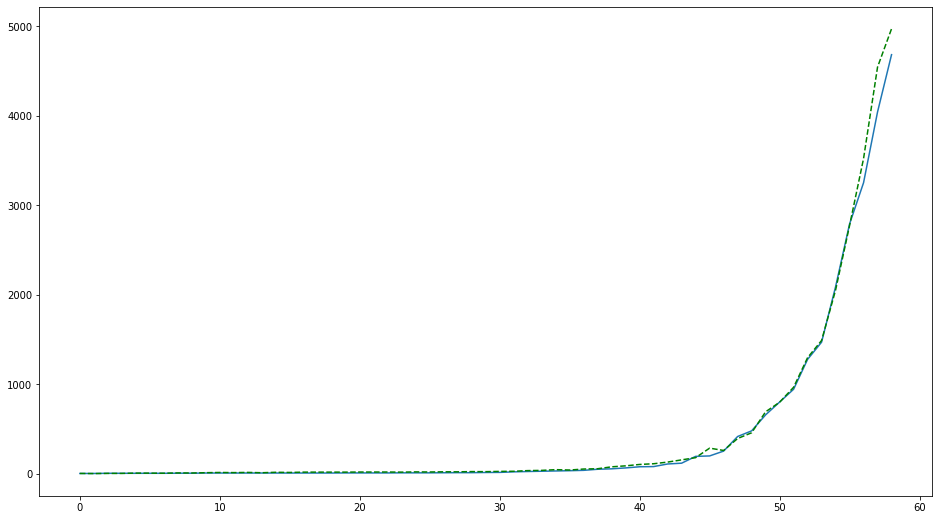

In [8]:
linear_model = LinearRegression(normalize=True, fit_intercept=False)
linear_model.fit(X_train, y_train)
pred = linear_model.predict(X)

con_series_values.shape
plt.figure(figsize=(16, 9))
plt.plot(days, y)
plt.plot(days, pred, linestyle='dashed', color='green')
plt.show()

### policy data

In [9]:
measure = pd.read_csv("covid_19_government.csv")
measure.head()

,ID,Applies To,Country,Date Start,Date end intended,Description of measure implemented,Exceptions,Implementing City,Implementing State/Province,Keywords,Quantity,Source,Target city,Target country,Target region,Target state
0,163,NaN,Austria,"Mar 16, 2020",NaN,On 10 March 2020 government announced that all...,NaN,NaN,NaN,university closure,NaN,https://en.wikipedia.org/wiki/2020_coronavirus...,NaN,NaN,NaN,NaN
1,132,NaN,Germany,"Feb 01, 2020",NaN,"102 German citizens and 26 relatives, all of w...",NaN,NaN,NaN,"international traveller screening, traveller q...",NaN,https://www.tagesschau.de/inland/coronavirus-g...,NaN,NaN,NaN,NaN
2,578,NaN,United Kingdom,"Mar 20, 2020",NaN,"All schools, nurseries and colleges closed.",NaN,NaN,NaN,"nursery schools closure, school closure, unive...",NaN,https://www.theguardian.com/world/2020/mar/18/...,NaN,NaN,NaN,NaN
3,372,NaN,United Kingdom,"Mar 16, 2020",NaN,If one person in any household has a persisten...,NaN,NaN,NaN,"14 days, contact isolation",NaN,https://www.bbc.com/news/uk-51920444,NaN,NaN,NaN,NaN
4,357,NaN,United Kingdom,"Mar 16, 2020",NaN,"By the weekend, those with the most serious he...",NaN,NaN,NaN,isolation advice to elderly,NaN,https://www.bbc.com/news/uk-51920444,NaN,NaN,NaN,NaN


In [10]:
def process_measure(measure, country):
    ## First lets drop empty measures
    measure = measure[measure['Description of measure implemented'].notna()]
    measure = measure[measure['Date Start'].notna()]
    measure = measure[measure['Keywords'].notna()]
    measure['Date Start'] = pd.to_datetime(measure['Date Start'])

    measure_value = measure[['Country','Date Start','Keywords']].sort_values('Date Start')
    c = measure_value[measure_value['Country'] == country]
    c = c.reset_index(drop=True)
    c.to_csv("{}_government.csv".format(country), index=False)

### train on Italy

In [11]:
italy = pd.read_csv("Italy_government.csv")
italy['Date Start'] = pd.to_datetime(italy['Date Start'])
italy = italy.groupby('Date Start').max().sort_values('Date Start')
italy = italy.reset_index()[['Date Start', 'Level']]

dates = pd.DataFrame(con_series_df.columns[2:])
dates[0] = pd.to_datetime(dates[0])
dates = dates.rename(columns={0: 'Date Start'})

In [12]:
level = []
t = 0
for index1, row1 in dates.iterrows():
    appended = False
    for index2, row2 in italy.iterrows():
        if row1[0] == row2[0]:
            level.append(row2[1])
            appended = True
            t = row2[1]
            break
    if not appended:
        level.append(t)
level = np.array(level)
level = level.reshape((66, 1))

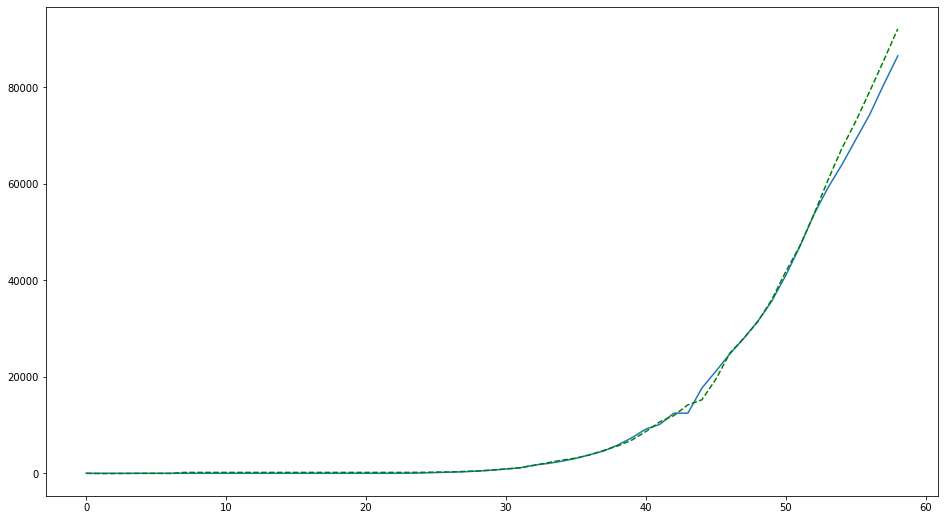

In [13]:
con_series_df = pd.read_csv("time_series_covid_19_confirmed.csv")
con_series_df = con_series_df[con_series_df['Country/Region'] == 'Italy']
con_series_df = con_series_df.groupby(['Country/Region']).sum()
con_series_values = con_series_df.drop(columns=['Lat', 'Long']).values
con_series_values = con_series_values.reshape(-1, 1)

italy_data = series_to_supervised(np.append(level, con_series_values, axis=1), 7, 1).values
X = italy_data[:, :-2]
y = italy_data[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

linear_model = LinearRegression(normalize=True, fit_intercept=False)
linear_model.fit(X_train, y_train)
pred = linear_model.predict(X)

plt.figure(figsize=(16, 9))
plt.plot(days, y)
plt.plot(days, pred, linestyle='dashed', color='green')
plt.show()

### train on China

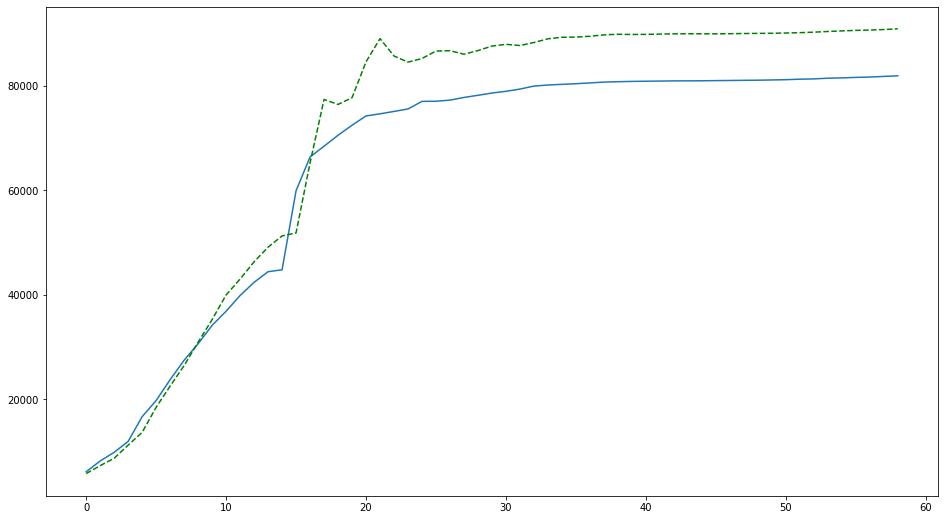

In [14]:
china = pd.read_csv("China_government.csv")

china['Date Start'] = pd.to_datetime(china['Date Start'])
china = china.groupby('Date Start').max().sort_values('Date Start')
china = china.reset_index()[['Date Start', 'Level']]

level = []
t = 0
for index1, row1 in dates.iterrows():
    appended = False
    for index2, row2 in china.iterrows():
        if row1[0] == row2[0]:
            level.append(row2[1])
            appended = True
            t = row2[1]
            break
    if not appended:
        level.append(t)
level = np.array(level)
level = level.reshape((66, 1))

con_series_df = pd.read_csv("time_series_covid_19_confirmed.csv")
con_series_df = con_series_df[con_series_df['Country/Region'] == 'China']
con_series_df = con_series_df.groupby(['Country/Region']).sum()
con_series_values = con_series_df.drop(columns=['Lat', 'Long']).values
con_series_values = con_series_values.reshape(-1, 1)

china_data = series_to_supervised(np.append(level, con_series_values, axis=1), 7, 1).values
X = china_data[:, :-2]
y = china_data[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

pred = linear_model.predict(X)

plt.figure(figsize=(16, 9))
plt.plot(days, y)
plt.plot(days, pred, linestyle='dashed', color='green')
plt.show()

## combine italy data and china data and train

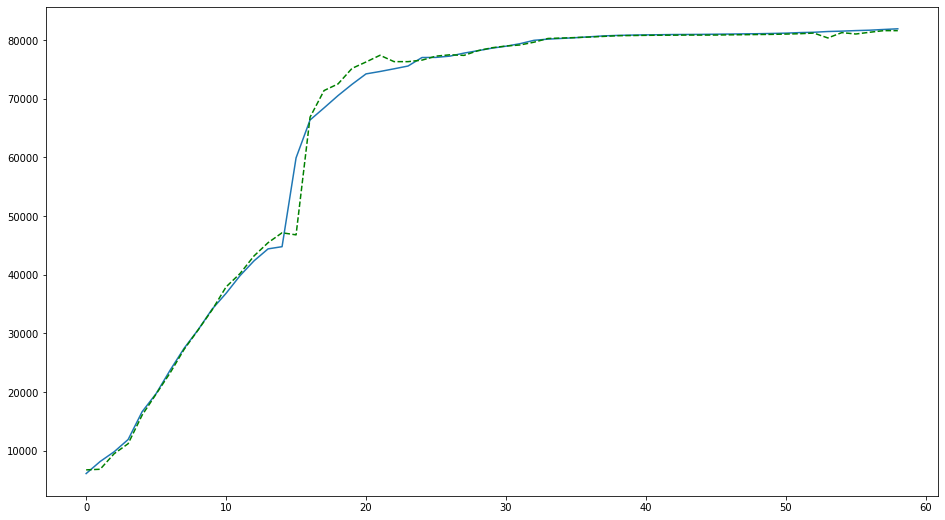

In [40]:
combined_data = np.append(italy_data, china_data, axis=0)
X = combined_data[:, :-2]
y = combined_data[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

linear_model = LinearRegression(normalize=True, fit_intercept=False)
linear_model.fit(X_train, y_train)

pred = linear_model.predict(china_data[:, :-2])

plt.figure(figsize=(16, 9))
plt.plot(days, china_data[:, -1])
plt.plot(days, pred, linestyle='dashed', color='green')
plt.show()